In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs, plot_numerical_diffs_single

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v2...


In [3]:
# non tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]

# tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 96 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 94 registers, 448 bytes cmem[0]

## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [4]:
from src.gpu_info.gpu_info import get_gpu_info

In [5]:
# get_gpu_info(0)

### define inputs

In [6]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 64 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [7]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
# qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [8]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [9]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [10]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [11]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [12]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [13]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: True, max diff: 3.339519025757909e-07
fw n match: False, max diff: 0.04561877250671387
fw m match: False, max diff: 0.030748605728149414
fw D match: False, max diff: 0.01139909029006958
====== Full -> bfloat16 ======
fw hs match: True, max diff: 6.795955414418131e-06
fw n match: False, max diff: 0.1731654405593872
fw m match: False, max diff: 0.14853811264038086
fw D match: False, max diff: 0.07008630037307739


### match directly

In [14]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [15]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

In [16]:
s_pt_half = (qs_half @ ks_half.transpose(-2, -1)).tril()
s_pt_half.shape

torch.Size([1, 1, 64, 64])

In [17]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 64
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-1, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 67840
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


In [18]:
ks_half[:, :, 16:32, 16:]

tensor([[[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0

In [19]:
qs_half[:, :, 16:32, 32:]

tensor([[[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 

In [20]:
s_pt_half[:, :, :16, :16]

tensor([[[[0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0

In [21]:
matD_cu_half[:, :, :16, 16:50]

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 

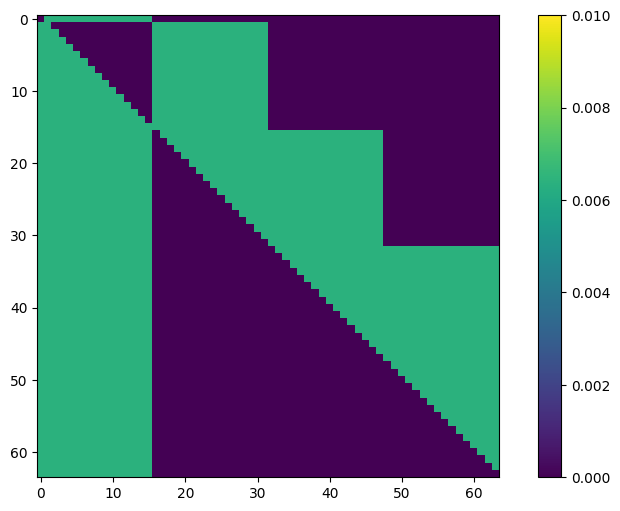

In [22]:
fig = plot_numerical_diffs_single(s_pt_half, matD_cu_half)

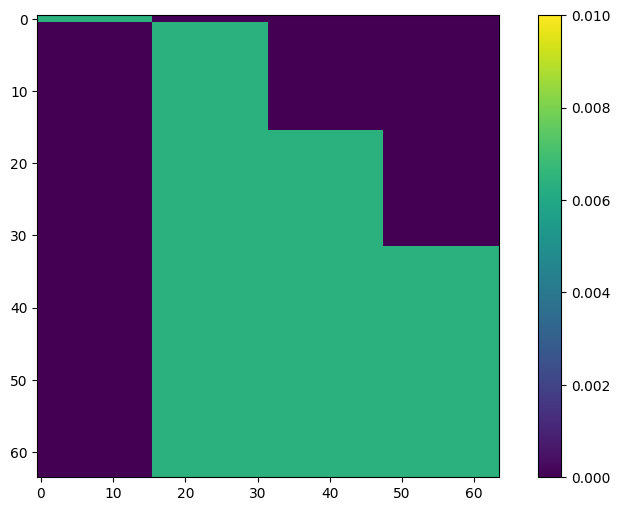

In [23]:
fig = plot_numerical_diffs_single(matD_cu_half)

In [24]:
s_pt_half[:, :, :10, :10]

tensor([[[[0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064]]]], device='cuda:0', dtype=torch.float16)

In [25]:
(s_pt_half - matD_cu_half)[:, : , :10, :10]

tensor([[[[ 0.0000, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064, -0.0064],
          [ 0.0064,  0.0064,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0000,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0000,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0000],
          [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,  0.0064,

In [26]:
(s_pt_half - matD_cu_half).abs().max()

tensor(0.0064, device='cuda:0', dtype=torch.float16)

In [27]:
vs_half[:, :, :3, 32:]

tensor([[[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100]]]], device='cuda:0', dtype=torch.float16)

In [28]:
matD_cu_half.shape

torch.Size([1, 1, 64, 64])

In [29]:
matD_cu_half[:, :, :10, :10]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]], device='cuda:0', dtype=torch.float16)

In [30]:
hs_cu_half[:, :, :3, 32:]

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0', dtype=torch.float16)

In [31]:
(vs_half-hs_cu_half)[:, :, :3, 32:]

tensor([[[[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
           0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100]]]], device='cuda:0', dtype=torch.float16)

In [32]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 64
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-1, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 67840
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


In [33]:
matD_cu_bf16[:, :, :10, :10]

tensor([[[[0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]], device='cuda:0', dtype=torch.bfloat16)

In [34]:
s_pt_half[:, :, :10, :10]

tensor([[[[0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0000],
          [0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064, 0.0064]]]], device='cuda:0', dtype=torch.float16)

In [35]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 64, 64]), torch.Size([1, 1, 64, 64]))

In [36]:
hs_cu_half, qs

(tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [37]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 49.53929138183594
====== Half ======
fw hs match: False, max diff: 0.00013583405234385282
fw n match: False, max diff: 4.277872085571289
fw m match: False, max diff: 2.679403781890869
fw D match: False, max diff: 49.53929138183594
====== bfloat16 ======
fw hs match: False, max diff: 0.00013583405234385282
fw n match: False, max diff: 4.277872085571289
fw m match: False, max diff: 2.679403781890869
fw D match: False, max diff: 49.53929138183594


In [38]:
16 / 4

4.0

In [39]:
13 % 4, 14 % 4

(1, 2)

In [40]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

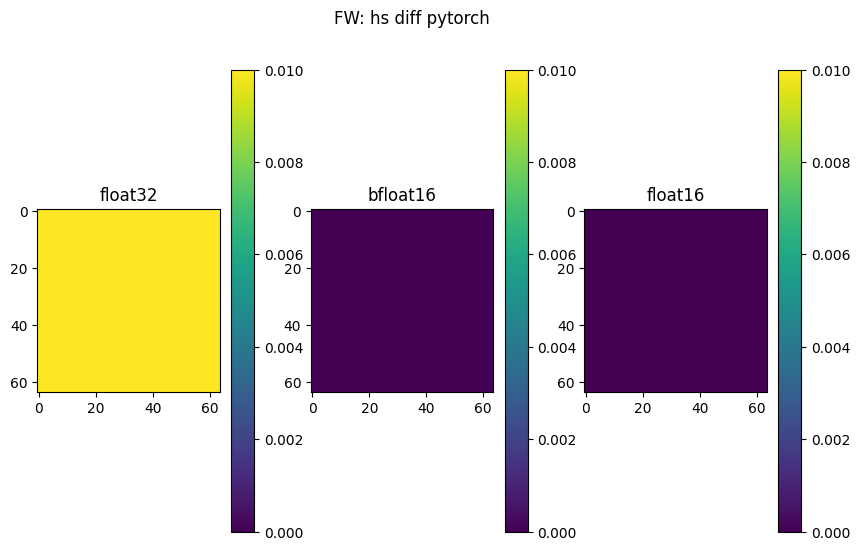

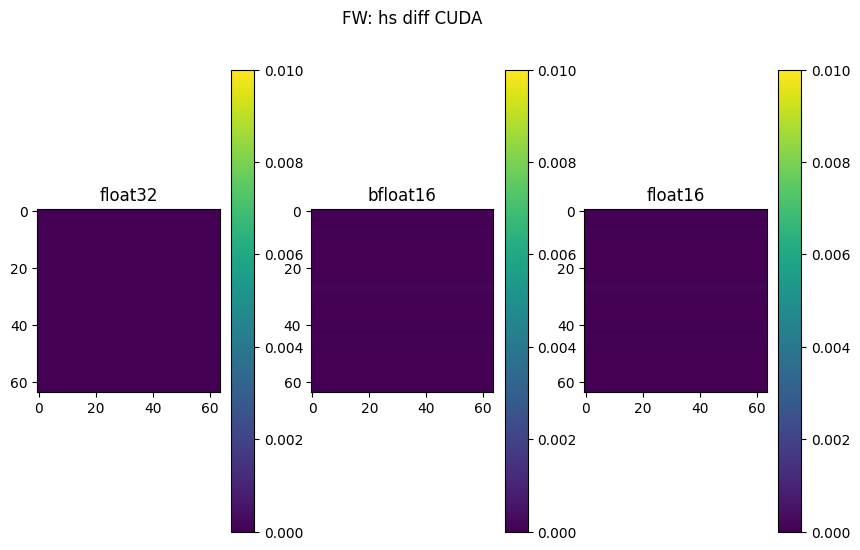

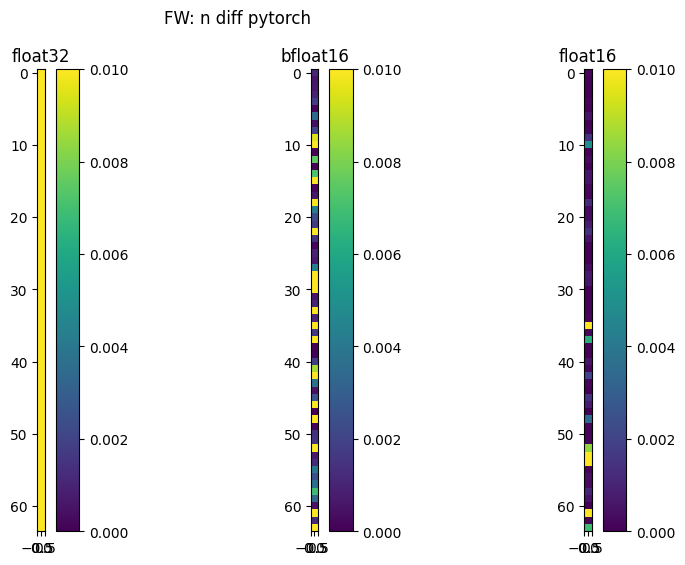

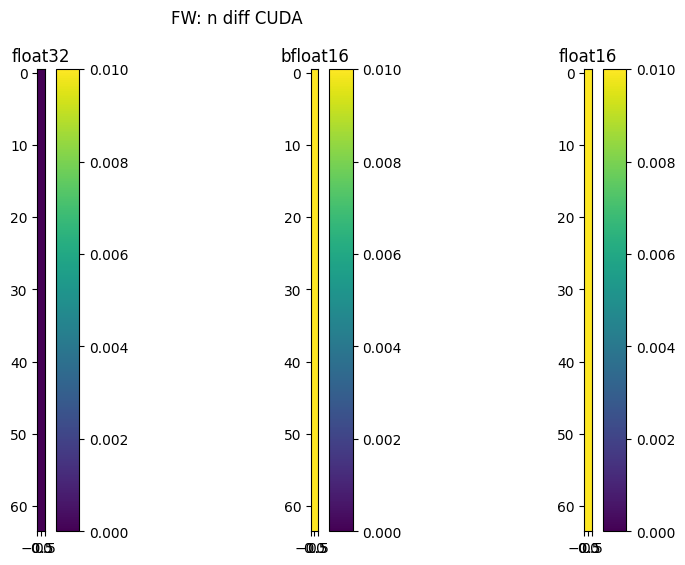

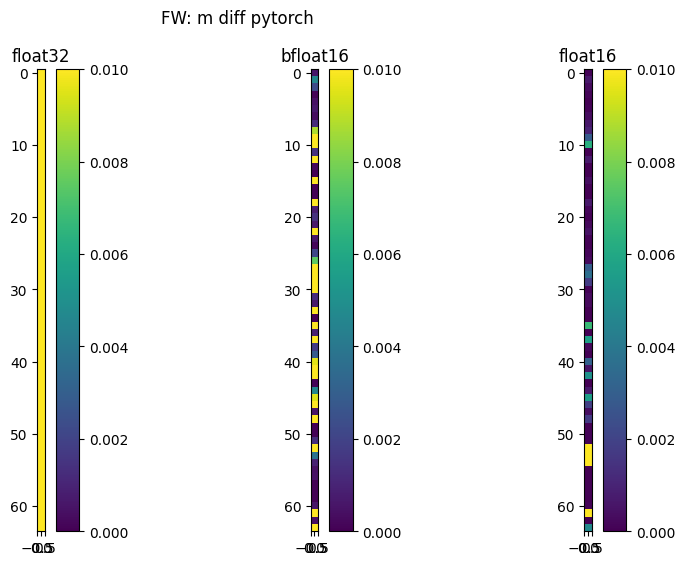

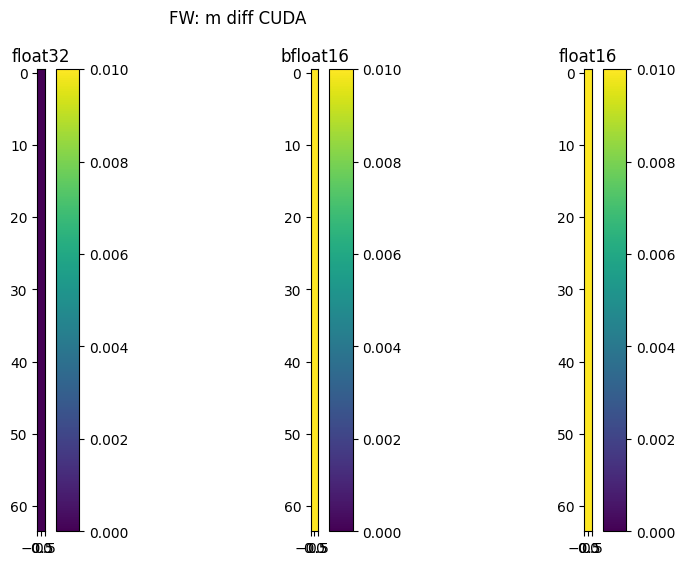

In [41]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")